In [39]:
!pip install pypinyin

In [40]:
import torch
import os
from torch import nn 
import numpy as np 
import random
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from pypinyin import load_phrases_dict, Style, load_single_dict, lazy_pinyin

In [41]:
# 参数dict
Config = {
    'model_save_path':'/content/drive/MyDrive/pic2poem_4th_edition/modelDict/',
    'loss_path':'/content/drive/MyDrive/pic2poem_4th_edition/plot_data/loss.npy',
    'acc1_path':'/content/drive/MyDrive/pic2poem_4th_edition/plot_data/acc1.npy',
    'acc5_path':'/content/drive/MyDrive/pic2poem_4th_edition/plot_data/acc5.npy',
    'title2keywords_path':"/content/drive/MyDrive/pic2poem_4th_edition/dict_data/title-keywords.npy",
    'title2poem_path':"/content/drive/MyDrive/pic2poem_4th_edition/dict_data/title-poem.npy",
    'n2w_save_path':'/content/drive/MyDrive/pic2poem_4th_edition/dict_data/n2w.npy',
    'w2n_save_path':'/content/drive/MyDrive/pic2poem_4th_edition/dict_data/w2n.npy',
    'embedding_dim':200,
    'hidden_dim':1024,
    'batch_size':64,
    'lr':0.0008,
    'num_LSTM_layers':4,
    'num_epochs':30
}

In [42]:
# 获取并查看title2keywords和title2poem
import numpy as np

title_keywords = np.load(Config['title2keywords_path'], allow_pickle=True)
title_poem = np.load(Config['title2poem_path'], allow_pickle=True)

title_keywords = title_keywords.item()

title_poem = title_poem.item()

cnt = 0
for i in title_poem:
  print(title_poem[i])
  print(title_keywords[i])
  cnt += 1
  if cnt > 10:
    break

['三春休晦节，九谷泛年华。', '半晴馀细雨，全晚澹残霞。', '尊开疎竹叶，管应落梅花。', '兴阑相顾起，流水送香车。']
['水', '雨', '霞', '花']
['忽闻莺响谷，于此命相知。', '正开彭泽酒，来向高阳池。', '柳叶风前弱，梅花影处危。', '赏洽林亭晚，落照下参差。']
['酒', '柳', '花']
['汉东不执象，河朔方鬬龙。', '夏灭渐宁乱，唐兴终奋庸。', '皇威正赫赫，兵气何匈匈。', '用武三川震，归淳六代醲。', '成臯覩王业，天下致人雍。', '即此巡于岱，曾孙受命封。']
['人', '兵']
['在昔尧舜禹，遗尘成典谟。', '圣皇东巡狩，况乃经此都。', '楼观纷迤逦，河山几萦纡。', '缅怀祖宗业，相继文武图。', '尚德既无险，观风谅有孚。', '岂如汾水上，箫鼓事游娱。']
['山', '水']
['太原俗尚武，高皇初奋庸。', '星轩三晋躔，土乐二尧封。', '北风遂举鹏，西河亦上龙。', '至德起王业，继明赖人雍。', '六合启昌期，再兴广圣踪。', '传呼大驾来，文物如云从。', '连营火百里，纵观人千重。', '翠华渡汾水，白日临崒峰。', '枌榆恩赏洽，桑梓旧情恭。', '往运感不追，清时惜难逢。', '诗发尊祖心，颂刊盛德容。', '愿君及春事，廻舆绥万邦。']
['人', '水', '星']
['树德岂孤迈，降神良竝出。', '伟兹廊庙桢，调彼盐梅实。', '正悦虞垂举，翻悲郑侨卒。', '同心不可忘，交臂何为失。', '清路荷前幸，明时称右弼。', '曾联野外游，尚记帷中密。', '新恸情莫遣，旧游词更述。', '空令还辱和，长歎知音日。']
['路']
['朝上高楼上，俯见洛阳陌。', '摇荡吹花风，落英纷已积。', '美人不共此，芳好空所惜。', '揽镜尘网滋，当窗苔藓碧。', '缅怀在云汉，良愿暌枕席。', '翻似无见时，如何久为客。']
['人', '花']
['楚有章华台，遥遥云梦泽。', '复闻拥符传，及是收图籍。', '佳政在离人，能声寄侯伯。', '离怀朔风起，试望秋阴积。', '中路悽以寒，羣山霭将夕。', '伤心聊把袂，怊怅麒麟客。']
['人', '山', '路']
['桐栢膺新命，芝兰惜旧游。', '鸣臯夜鹤在，迁木早莺求。', '传拥淮源路，尊空灞水流。', '落花

In [43]:
# 根据数据集生成字典
n2w = {}
w2n = {}
n = 3

for poem in title_poem.values():
  for sentence in poem:
    for char in sentence:
      # print(char)
      if not (char in w2n):
        # print(char)
        w2n[char] = n
        n2w[n] = char
        n += 1
n2w[0] = '<' # 开始符号
w2n['<'] = 0
n2w[1] = '>' # 结束符号
w2n['>'] = 1
n2w[2] = 'p'  # padding
w2n['p'] = 2

In [44]:
# 保存字典
np.save(Config['n2w_save_path'],n2w)
np.save(Config['w2n_save_path'],w2n)

In [45]:
# 定义数据集
class PoemDataset(data.Dataset):
    def __init__(self, t2k, t2s, w2n, n2w, seqlen, keyword_num, split): # seq_len表示一个样本中诗句的长度
      # 数据集划分
      self.split = split
      self.seq_len = seqlen
      self.keyword_num = keyword_num

      word2num = np.load(w2n, allow_pickle=True)
      num2word = np.load(n2w, allow_pickle=True)
      self.word2num = word2num.item()
      self.num2word = num2word.item()

      title2keywords = np.load(t2k, allow_pickle=True)
      title2poem = np.load(t2p, allow_pickle=True)
      self.title2keywords = title2keywords.item()
      self.title2poem = title2poem.item()

      keywords = []
      sentence_in = []
      sentence_label = []

      # 根据npy生成数组
      for item in self.title2keywords:
        cur_poem = self.title2poem[item]
        cur_keywords = self.title2keywords[item]
        # 限制关键词个数在seq_len以内
        while len(cur_keywords) < self.keyword_num:
          cur_keywords.append('p')
        cur_keywords = cur_keywords[0:self.keyword_num]
        # print(len(cur_keywords))

        # 按照句子添加到sentence中
        for s in cur_poem:
          tmps = '<' + s + '>' # 添加开始和结束符号
          tmpslist = list(tmps) # 转换为list
          # 长度限制为seqlen
          while len(tmpslist) < self.seq_len:
            tmpslist.append('p')
          tmpslist = tmpslist[0:self.seq_len] 
          tmpslist = [self.word2num[char] for char in tmpslist] # 字符转换为num
        

          sentence_in.append(tmpslist[:-1:]) # 去除最后一个字符，作为输入
          sentence_label.append(tmpslist[1::]) # 去除第一个字符，作为标签
          
          cur_keywords_list = list(cur_keywords) # 关键词同样的操作(keyword本身就为list)
          cur_keywords_list = [self.word2num[char] for char in cur_keywords_list]
          keywords.append(cur_keywords_list)

      self.keywords = keywords
      self.sentence_in = sentence_in
      self.sentence_label = sentence_label

      self.dataset_size = len(self.keywords)

      # 图片
      # self.img = 

    def __getitem__(self, i):
      keyword = torch.LongTensor(self.keywords[i])

      label = self.sentence_label[i]
      label = torch.from_numpy(np.array(label)).long()
      input = self.sentence_in[i]
      input = torch.from_numpy(np.array(input)).long()

      # return keyword, teacher, student
      return input, label

    def __len__(self):
      return self.dataset_size

In [46]:
# 创建数据集

# title2keywords 路径
t2k = Config['title2keywords_path']

# title2poem 路径
t2p = Config['title2poem_path']

# 字典路径
n2w = Config['n2w_save_path']
w2n = Config['w2n_save_path']

dataset = PoemDataset(t2k, t2p, w2n, n2w, 14, 5, "TRAIN")

In [47]:
# 测试数据集
input_i, label_i = dataset.__getitem__(30)

# keywords = [dataset.num2word[num] for num in keywords]
label_i = [dataset.num2word[num] for num in label_i.tolist()]
input_i = [dataset.num2word[num] for num in input_i.tolist()]

# print(keywords)
print(label_i)
print(input_i)

print(dataset.__len__())
print(len(dataset.sentence_in))
print(len(dataset.sentence_label))
print(len(dataset.keywords))

['诗', '发', '尊', '祖', '心', '，', '颂', '刊', '盛', '德', '容', '。', '>']
['<', '诗', '发', '尊', '祖', '心', '，', '颂', '刊', '盛', '德', '容', '。']
77255
77255
77255
77255


In [48]:
# 获取字典
n2w = dataset.num2word
w2n = dataset.word2num

In [49]:
# 测试字典
print(w2n['者'])
print(len(w2n))

697
6285


In [50]:
# 创建dataloader
dataloader = DataLoader(dataset, batch_size=Config['batch_size'], shuffle=True)

In [51]:
# 测试dataloader
for i, item in enumerate(dataloader):
  for things in item:
    print(things.shape)
  break
print(len(dataloader))  

torch.Size([64, 13])
torch.Size([64, 13])
1208


In [52]:
class PoemModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoemModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) 
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, 
                    num_layers=Config['num_LSTM_layers'], batch_first=True) # 根据数据集返回的sample，需要batch_first
        self.fc1 = nn.Linear(self.hidden_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 4096)
        self.fc4 = nn.Linear(4096, vocab_size) # 输出维度与vocab大小相同

    def forward(self, input, hidden=None):
        # batch，seqlen
        embedding = self.embeddings(input)  
        # batch, seqlen, embedding_dim
        batch_size, seq_len = input.size()

        # 根据输入的hidden选择是否进行初始化
        if hidden is None:
            h_0 = torch.zeros((Config['num_LSTM_layers'], batch_size, self.hidden_dim),dtype=torch.float).to(input.device)
            c_0 = torch.zeros((Config['num_LSTM_layers'], batch_size, self.hidden_dim),dtype=torch.float).to(input.device)
        else: # 用于古诗生成
            h_0, c_0 = hidden

        # 前向
        output, hidden = self.lstm(embedding, (h_0, c_0))
        output = torch.tanh(self.fc1(output))
        output = torch.tanh(self.fc2(output))
        output = torch.tanh(self.fc3(output))
        output = self.fc4(output)

        # 平整为batch_size * seq_len， vocab_size       
        output = output.reshape(batch_size * seq_len, -1) 

        return output, hidden

In [53]:
# 准确率计算（topk）
def accuracy(output, label, topk):

    # 此时：
    # label shape: batch_size * seq_len
    # ouput shape: batch_size * seq_len, vocab_size 
    
    # 获取label的长度（需要比较的字的个数）
    length = label.size(0)

    # 将label增加一维，以方便下一步拓展到与topk相同的形状
    label = label.reshape(label.size(0), 1)

    # output每一个字的topk的索引
    _, topk_indices = output.topk(topk, dim=1, largest=True)
    # topk_indices shape: batch_size * seqlen, topk

    # 将label拓展至topk相同形状
    label = label.expand_as(topk_indices)
    # label shape: batch_size * seqlen, topk

    # 进行比较, 得到true/fulse矩阵
    result = topk_indices.eq(label)

    # 统计正确的数量(true的个数)
    result = result.reshape(-1).float().sum(0)
    return result.mul_(100.0 / length)

In [54]:
def train(epochs, dataloader, device, model, criterion, optimizer, schedular, loss_set, acc1_set, acc5_set):
  # 放入设备中
  model = model.to(device)
  # 训练模式
  model.train()
  
  # 迭代训练
  for epoch in range(epochs):
    # 初始化准确率
    epoch_acc1 = 0.0
    epoch_acc5 = 0.0
    # 初始化loss
    epoch_loss = 0.0
    
    # 进度条
    dataloader = tqdm(dataloader)
    # 当前epoch的训练速率
    dataloader.set_description('[%s%04d/%04d %s%f]' % ('Epoch:', epoch + 1, epochs, 'lr:', scheduler.get_last_lr()[0]))
    
    # per batch
    for i, data in enumerate(dataloader, 0):
      # 获取输入和标签
      inputs, labels = data[0].to(device), data[1].to(device)

      # 平整labels，便于计算准确率
      labels = labels.reshape(-1)
      
      # 清空历史梯度
      optimizer.zero_grad()
      
      # 前向
      outputs, hidden = model(inputs)

      # # 测试输出
      # if i % 200 == 0 :
      #   print('[%s%d%s]' % ('No.', i + 1, 'batch'))
      #   print("输入为")
      #   inputs_print = inputs.reshape(-1)
      #   inputs_print = inputs_print.cpu().detach().numpy().tolist()
      #   inputs_print = [n2w[x] for x in inputs_print]
      #   print(inputs_print)
      #   print("标签为")
      #   label_words = labels.cpu().detach().numpy().tolist()
      #   label_words = [n2w[x] for x in label_words]
      #   print(label_words)
      #   print("输出为")
      #   output_words = outputs.topk(1)[1].cpu().detach().numpy()
      #   output_words = np.squeeze(output_words)
      #   output_words = [n2w[x] for x in output_words]
      #   print(output_words)

      # 计算loss
      loss = criterion(outputs,labels)
      # 反向传播
      loss.backward()
      # 更新参数
      optimizer.step()
      
      # 计算平均准确率
      acc1 = accuracy(outputs, labels, 1) # top1
      epoch_acc1 = (epoch_acc1 * i + acc1) / (i + 1)
      acc5 = accuracy(outputs, labels, 5) # top5
      epoch_acc5 = (epoch_acc5 * i + acc5) / (i + 1)
      
      # 计算损失
      epoch_loss = (epoch_loss * i + loss) / (i + 1)

      # 更新显示
      postfix = {'train_loss': '%.6f' % epoch_loss,'train_acc1': '%.6f' % epoch_acc1, 'train_acc5': '%.6f' % epoch_acc5}
      dataloader.set_postfix(log=postfix)

      # 曲线绘制
      loss_set.append(loss)
      acc1_set.append(acc1)
      acc5_set.append(acc5)

    # 超参数步进
    scheduler.step()

In [92]:
# 实例化模型
model = PoemModel(len(w2n), embedding_dim=Config['embedding_dim'], hidden_dim=Config['hidden_dim'])

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 训练参数
epochs = Config['num_epochs']

# 优化器
optimizer = optim.Adam(model.parameters(), lr=Config['lr'])

# lr decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 16, gamma=0.1)

# 损失函数（多分类使用交叉熵）
criterion = nn.CrossEntropyLoss()

In [56]:
# 输出模型结构
model

PoemModel(
  (embeddings): Embedding(6285, 200)
  (lstm): LSTM(200, 1024, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=6285, bias=True)
)

In [93]:
# 模型训练

# 作图数据
loss_set = []
acc1_set = []
acc5_set = []

train(epochs, dataloader, device, model, criterion, optimizer,scheduler, loss_set, acc1_set, acc5_set)

In [94]:
# 模型保存
name = input("save as:")
if os.path.exists(Config['model_save_path']) == False: 
  os.mkdir(Config['model_save_path'])
if os.path.exists(Config['model_save_path'] + name) == True: 
  print('failed because name used')  
else:
  torch.save(model.state_dict(), Config['model_save_path']+name)
  print('pth file saved as ', Config['model_save_path']+name)

save as:model85.pth
pth file saved as  /content/drive/MyDrive/pic2poem_4th_edition/modelDict/model85.pth


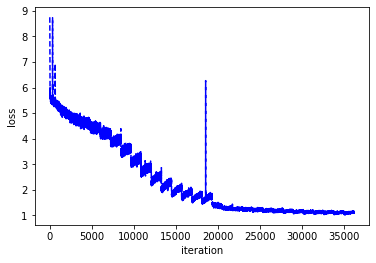

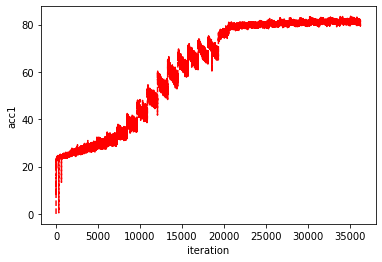

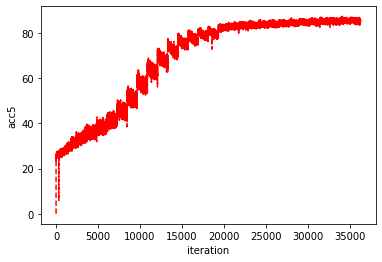

In [95]:
#作图
import matplotlib.pyplot as plt
%matplotlib inline

# training loss curve
plt.figure()
plt.plot(loss_set, 'b--')
plt.xlabel('iteration')
plt.ylabel('loss')
# acc1 accuracy curve
plt.figure()
plt.plot(acc1_set, 'r--')
plt.xlabel('iteration')
plt.ylabel('acc1');
# acc5 accuracy curve
plt.figure()
plt.plot(acc5_set, 'r--')
plt.xlabel('iteration')
plt.ylabel('acc5');

In [61]:
# 保存曲线数据
np.save(Config['loss_path'],loss_set)
np.save(Config['acc1_path'],acc1_set)
np.save(Config['acc5_path'],acc5_set)

In [62]:
# 押韵
def choose_correct_word(pre_word, possible_list):
    
    tone = lazy_pinyin(pre_word, style=Style.FINALS)
    #print('tone is '+str(tone))
    wordsd = lazy_pinyin(pre_word, style=Style.TONE3)
    wordsd = wordsd[0][-1]
    #print('wsd is '+ wordsd)
    tonelist = lazy_pinyin(possible_list, style=Style.FINALS)
    finalist = []
    #保证押韵
    for i in range(len(tonelist)):
        if tone[0] == tonelist[i]:
            finalist.append(possible_list[i])
    #保证平仄
    shengdiao = lazy_pinyin(finalist, style=Style.TONE3)
    #print(shengdiao)
    for i in range(len(shengdiao)):
        if int(wordsd) <= 2:
            if int(shengdiao[i][-1]) > 2:
                #保证声母不同
                if lazy_pinyin(pre_word, style=Style.INITIALS) != lazy_pinyin(finalist[i], style=Style.INITIALS):
                    return finalist[i]
        elif int(wordsd) > 2:
            if int(shengdiao[i][-1]) <= 2:
                if lazy_pinyin(pre_word, style=Style.INITIALS) != lazy_pinyin(finalist[i], style=Style.INITIALS):
                    return finalist[i]                    

In [97]:
# 生成诗句
def write(model, input_seq, n2w, w2n, device):

  sentence = input_seq
  
  # 加上起始符
  input_seq = '<' + input_seq
  # 获取起始部分长度
  input_seq_len = len(input_seq)
  # 转换为list
  input_seq = list(input_seq)

  # 初始状态
  hidden = torch.zeros((2, Config['num_LSTM_layers'], 1, Config['hidden_dim']), dtype=torch.float)

  # device相关
  model = model.to(device)
  hidden = hidden.to(device)

  model.eval()
  with torch.no_grad():
    for i in range(input_seq_len):
      # 在句首使用teacher forcing，获取隐藏状态
      input = torch.Tensor([w2n[input_seq[i]]]).view(1, -1).long().to(device)
      # 送入模型
      output, hidden = model(input, hidden)

    for i in range(12):
      # 押韵
      if len(sentence) == 10:     
        # 获取topk
        topk = output.data[0].topk(1000)[1].detach().to('cpu').numpy().tolist()
        topk = [n2w[x] for x in topk]
        sentence += choose_correct_word(sentence[4], topk)
        sentence += '。'
        break

      if len(sentence) == 5:
        # 获取top1
        top_indice = output.data[0].topk(1)[1][0].item()
      else:
        # 获取top3
        top_indice = output.data[0].topk(3)[1][random.randint(0, 2)].item()

      # 根据上一步的输出获取下一步的输入
      input = torch.Tensor([top_indice]).view(1, -1).long().to(device)
      # 加入句子中
      sentence += n2w[top_indice]
      # 迭代
      output, hidden = model(input, hidden)
    
    # sentence = sentence[:-2]
      
    return sentence # 去掉结束符号

In [108]:
# 生成诗句
def write_without_rhyme(model, input_seq, n2w, w2n, device):

  sentence = input_seq
  
  # 加上起始符
  input_seq = '<' + input_seq
  # 获取起始部分长度
  input_seq_len = len(input_seq)
  # 转换为list
  input_seq = list(input_seq)

  # 初始状态
  hidden = torch.zeros((2, Config['num_LSTM_layers'], 1, Config['hidden_dim']), dtype=torch.float)

  # device相关
  model = model.to(device)
  hidden = hidden.to(device)

  model.eval()
  with torch.no_grad():
    for i in range(input_seq_len):
      # 在句首使用teacher forcing，获取隐藏状态
      input = torch.Tensor([w2n[input_seq[i]]]).view(1, -1).long().to(device)
      # 送入模型
      output, hidden = model(input, hidden)

    for i in range(10):

      if len(sentence) == 5:
        # 获取top1
        top_indice = output.data[0].topk(1)[1][0].item()
      else:
        # 获取top3
        top_indice = output.data[0].topk(3)[1][random.randint(0, 2)].item()

      # 根据上一步的输出获取下一步的输入
      input = torch.Tensor([top_indice]).view(1, -1).long().to(device)
      # 加入句子中
      sentence += n2w[top_indice]
      # 迭代
      output, hidden = model(input, hidden)
      
    return sentence + '。' 

In [122]:
sentence = write(model, '人', n2w, w2n, device)

print(sentence)

sentence_without_rhyme = write_without_rhyme(model, '火', n2w, w2n, device)

print(sentence_without_rhyme)

人生若烦肠，解步自流丧。
火云无尽用，蒋此比嚣尘。


In [ ]:
# 按照论文写的模型
import torch.nn as nn

#Encoder
class Enc(nn.Module): #Enc处理之前的信息
  # input_size vocab的大小， embedding_size 词嵌入的维数， hidden_size 隐藏状态的维数
  def __init__(self, input_dim, hidden_dim, embedding_dim):
    super(Enc, self).__init__()
    # self.input_size = input_size
    self.hidden_dim = hidden_dim
    # 词嵌入层
    self.embedding = nn.Embedding(input_dim, embedding_dim)
    # 双向GRU
    # self.BiGRU = nn.GRU(embedding_dim, hidden_dim, bidirectional = True)
    # 先使用单向GRU
    self.GRU = nn.GRU(embedding_dim, hidden_dim)

  def forward(self, hidden_state, sentence): # sentence仅代表上一句的信息
    # 获取词嵌入
    embedded = self.embedding(sentence)
    # 获取gru的输出
    # output, hidden_state = self.BiGRU(embeded, hidden_state)
    # 由于使用了双向，output需要变换为1维
    # output = output.contiguous().view(-1, self.hidden_dim * 2)

    # 获取gru的输出
    output, hidden_state = self.GRU(embedded, hidden_state)
    return output, hidden_state
  
  # 隐藏状态初始化（第一个句子在train中进行初始化）
  def initHiddenState(self):
    return torch.zeros(1,1, self.hidden_dim, device=device)



# Memory-based Decoder
class M-Dec(nn.Module):
    def __init__(self, hidden_dim, decoder_output_dim, encoded_v_num, encoded_v_dim, encoded_h_num, encoded_h_dim):
        super(M-Dec, self).__init__()
        self.hidden_dim = hiddem_dim
        self.decoder_output_dim = decoder_output_dim

        # 语境信息decoder
        self.encoded_h_num = encoded_h_num
        self.encoded_h_dim = encoded_h_dim        
        self.Ua = nn.Linear(self.encoded_h_dim, self.hidden_dim) #为什么需要2个hiddensize？ 一个是上一步的输出，一个是当前隐藏状态
        self.Wa = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.ua = nn.Linear(self.hidden_dim, self.hidden_h_num) 

        # 图片信息decoder
        self.encoded_v_num = encoded_v_num
        self.encoded_v_dim = encoded_v_dim
        self.Ub = nn.Linear(self.encoded_v_dim, self.hidden_dim)
        self.Wb = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.ub = nn.linear(self.hidden_dim, self.encoded_v_num)
 
        self.embedding = nn.Embedding(self.decoder_output_dim, self.hidden_dim) #decoder为什么还需要embedding？ 用于将前一个输出的词进行词嵌入 *注意：这里hiddensize和embeddingsize相同？
        # self.dropout = nn.Dropout(self.dropout_p)

        # 将原始的input，经过注意力的v和经过注意力的h 这3个向量结合
        self.combine = nn.Linear(self.encoded_v_dim, encoded_h_dim, hidden_dim)

        self.gru = nn.GRU(self.hidden_dim, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.decoder_output_dim)
 
        # test
        self.vat = nn.Linear(hidden_size, 1)
 
    def forward(self, last_decoder_output, last_hidden_state, encoder_output_v, encoder_ouput_h):
        embedded = self.embedding(last_decoder_output)         # 前一次的输出进行词嵌入
        # embedded = self.dropout(embedded)

        # 图片信息注意力
        b = self.Wb(last_hidden_state) + self.Ub(encoder_ouput_v) # 将上一隐藏状态和来自encoder的图片信息结合
        # b = b.view(-1, b.shape[-1])
        b = torch.tanh(b) # 非线性
        b = self.ub(b)  # 计算权重向量
        beta = F.softmax(b)
        attn_applied_v = torch.bmm(beta.unsqueeze(0),
                       encoder_ouput_v.unsqueeze(0))
        # 得到的是维度为encoded_v_dim的向量

        # 前文信息注意力
        a = self.Wa(last_hidden_state) + self.Ua(encoder_output_h) # 将上一隐藏状态和来自encoder的前文信息结合
        a = torch.tanh(a)
        a = self.ua(a)
        alpha = F.softmax(a)
        attn_applied_h = torch.bmm(alpha.unsqueeze(0),
                       encoder_ouput_h.unsqueeze(0))
        # 得到的是维度为encoded_h_dim的向量

        # 将两个encoded信息结合
        attn_applied = torch.cat((attn_applied_v[0], attn_applied_h[0]), 1)
        # 得到新的输入
        input = torch.cat((embedded[0], attn_applied[0]), 1)
        input = self.combine(input).unsqueeze(0)
        input = F.relu(input)
        
        # 送入GRU
        output, hidden = self.gru(input, last_hidden_state)

        output = F.log_softmax(self.output(output[0]), dim = 1)
        return output, hidden

    def initHidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))
 
        return result

# 主题纠正网络 topic memory network 输出为2*hiddenstate的维度
class TMN(nn.Module):
    def __init__(self, hidden_dim, decoder_output_dim, encoded_v_num, encoded_v_dim, encoded_h_num, encoded_h_dim):
        super(M-Dec, self).__init__()
        self.hidden_dim = hiddem_dim
        self.decoder_output_dim = decoder_output_dim

        # 语境信息decoder
        self.encoded_h_num = encoded_h_num
        self.encoded_h_dim = encoded_h_dim        
        self.Ua = nn.Linear(self.encoded_h_dim, self.hidden_dim) #为什么需要2个hiddensize？ 一个是上一步的输出，一个是当前隐藏状态
        self.Wa = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.ua = nn.Linear(self.hidden_dim, self.hidden_h_num) 

        # 图片信息decoder
        self.encoded_v_num = encoded_v_num
        self.encoded_v_dim = encoded_v_dim
        self.Ub = nn.Linear(self.encoded_v_dim, self.hidden_dim)
        self.Wb = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.ub = nn.linear(self.hidden_dim, self.encoded_v_num)
 
        self.embedding = nn.Embedding(self.decoder_output_dim, self.hidden_dim) #decoder为什么还需要embedding？ 用于将前一个输出的词进行词嵌入 *注意：这里hiddensize和embeddingsize相同？
        # self.dropout = nn.Dropout(self.dropout_p)

        # 将原始的input，经过注意力的v和经过注意力的h 这3个向量结合
        self.combine = nn.Linear(self.encoded_v_dim, encoded_h_dim, hidden_dim)

        self.gru = nn.GRU(self.hidden_dim, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.decoder_output_dim)
 
        # test
        self.vat = nn.Linear(hidden_size, 1)
 
    def forward(self, keywords, s, last_hidden_state, encoder_output_v, encoder_ouput_h):
        
        embedded_keywords = self.embedding(keywords) # 获取关键词的词向量
        
        keywords_representation = torch.Relu(self.input_representation(embedded_keywords)) # 将关键词转换为隐藏层表示（和s的维度相同） 
                
        attn_weight = embedded.T * s # elementwise相乘，得到相似性，作为attention的权重
        attn_weight = F.softmax(attn_weight)

        attned_keywords = torch.bmm(embedded_keywords, attn_weight) # 施加权重，得到加权后的关键词矩阵

        o = torch.cat(atten_keywords, s) # 拼接两个向量（维度 为 2* hidden_satate的维度）
        
        return o